# Sidekick - Project-Based Predictions
Perform predictions on single projects.

## Import
Import and general settings. Should be run every time at first.

In [1]:
%matplotlib inline
import os
import sys
sys.path.insert(0, os.path.abspath('../utils/')) # Add sibling to Python path
sys.path.insert(0, os.path.abspath('../src/')) # Add sibling to Python path
sys.stdout.flush() # Print output on the fly in Notebook
import matplotlib
matplotlib.rcParams['figure.figsize'] = (18,8)
matplotlib.rcParams['font.size'] = 16
matplotlib.rcParams['legend.fontsize'] = 16
from IPython.display import display
import numpy as np
import GPy
import cPickle as cp
import matplotlib.pyplot as plt
from math import floor
from dataset import Sidekick
from misc_utils import progress

DATA_DIR = "../data/sidekick"

warning in stationary: failed to import cython module: falling back to numpy


## Load data
This operation takes a lot of time, should be done only once.

In [2]:
sk = Sidekick()
project = sk['14035777']

## Plot status
Plot the pledged money and number of backers of the same figure.

Goal: $2500
Pledged: $2905


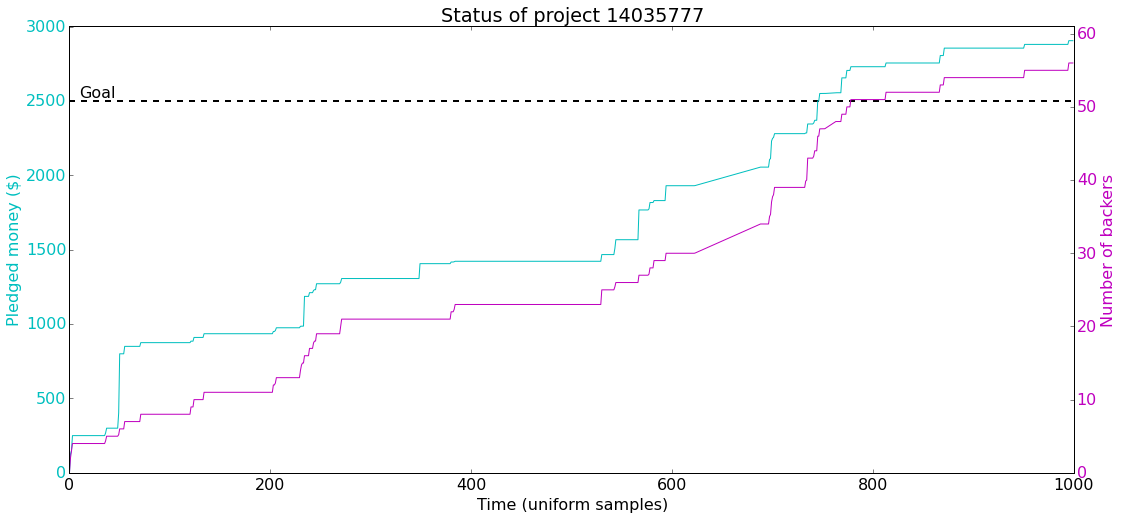

In [3]:
project.plot()

## Processing
We keep only the observations where there is a change from the previous one in order to reduce the quantity of data. The training and testing sets are also extracted. 

**Default size**: 80% for trainig, 20% for testing

In [23]:
threshold = 0.8
money = project.money
time, money = project.resample(money)
x_train, y_train, x_test, y_test = project.split(time, money, threshold)

## Training
Perform the regression on the training set.

### Kernels
We define some kernels to be tried.

In [21]:
# Primitives
LIN = GPy.kern.Linear(input_dim=1)
SE = GPy.kern.RBF(input_dim=1)
BR = GPy.kern.Brownian(input_dim=1) # √
POLY = GPy.kern.Poly(input_dim=1, order=3) # x
RQ = GPy.kern.RatQuad(input_dim=1)
WN = GPy.kern.White(input_dim=1)
MAT32 = GPy.kern.Matern32(input_dim=1)
MAT52 = GPy.kern.Matern52(input_dim=1)
CP200 = GPy.kern.ChangePointBasisFuncKernel(input_dim=1, changepoint=200)
CP400 = GPy.kern.ChangePointBasisFuncKernel(input_dim=1, changepoint=400)
DOM1 = GPy.kern.DomainKernel(input_dim=1, start=-1, stop=300)
DOM2 = GPy.kern.DomainKernel(input_dim=1, start=299, stop=500)
DOM3 = GPy.kern.DomainKernel(input_dim=1, start=499, stop=700)
DOM4 = GPy.kern.DomainKernel(input_dim=1, start=600, stop=1000)
DOM5 = GPy.kern.DomainKernel(input_dim=1, start=399, stop=500)
DOM6 = GPy.kern.DomainKernel(input_dim=1, start=499, stop=100)

#BIAS = GPy.kern.Bias()

# Combined
LIN_LINxSE = LIN.copy() + LIN.copy() * SE.copy() # √
SE_LINxSE = SE.copy() + LIN.copy() * SE.copy()
SE_SExSE = SE.copy() + SE.copy() * SE.copy()
LINxSE = LIN.copy() + SE.copy()
LINxLIN = LIN.copy() + LIN.copy()
BRxSE = BR.copy() * SE.copy()
BR_SE = BR.copy() + SE.copy()
BR_SExLIN = BR.copy() + SE.copy() * LIN.copy()
BRxBR = BR.copy() * BR.copy()
BR_BR = BR.copy() + BR.copy()
SE_POLY = SE.copy() * POLY.copy() # x
RQxSE = RQ.copy() + SE.copy() # √
LINxSE_RQxSE = RQxSE.copy() + LINxSE.copy()
LINxSE_SE = RQxSE.copy() + SE.copy()
LIN_RQ = LIN.copy() + RQ.copy()
LINxRQ = LIN.copy() * RQ.copy() # √
LINxRQxBR = LINxRQ.copy() * BR.copy() # √
LINxRQ_BR = LINxRQ.copy() + BR.copy()
LINxRQxBR_SE = LINxRQxBR.copy() + SE.copy()
RQxSE_WN = RQxSE.copy() + WN.copy()
POLY_SE = POLY.copy() + SE.copy()
LIN_MAT32 = LIN.copy() + MAT32.copy()
LIN_MAT52 = LIN.copy() + MAT52.copy()

# Piece-wise
DOM300 = GPy.kern.DomainKernel(input_dim=1, start=-1, stop=384)
DOM500 = GPy.kern.DomainKernel(input_dim=1, start=-1, stop=525)
DOM1000 = GPy.kern.DomainKernel(input_dim=1, start=525, stop=1000)

### Regression

GP_regression.,Value,Constraint,Prior,Tied to
sum.rbf_1.variance,1.61207639476,+ve,,
sum.rbf_1.lengthscale,499.989527514,+ve,,
sum.rbf.variance,0.00122814428887,+ve,,
sum.rbf.lengthscale,4.8185442779,+ve,,
Gaussian_noise.variance,1.29320766982e-05,+ve,,


{'dataplot': {'dataplot': [<matplotlib.lines.Line2D at 0x12a5811d0>]},
 'gpplot': [[<matplotlib.lines.Line2D at 0x110858f90>],
  [<matplotlib.lines.Line2D at 0x12a61f990>]]}

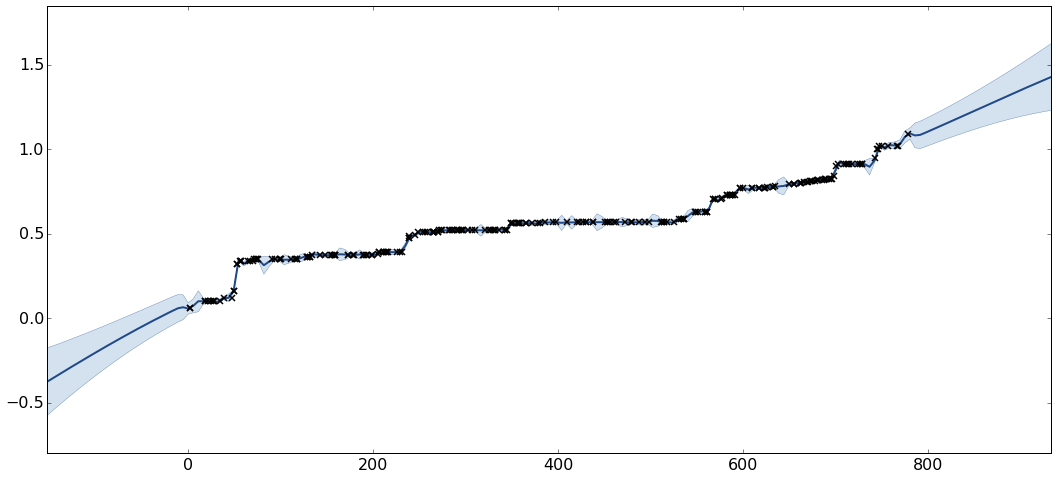

In [43]:
#kernel = SE.copy()
kernel = GPy.kern.RBF(input_dim=1, lengthscale=500)
kernel = GPy.kern.RBF(input_dim=1, lengthscale=500) + SE.copy()
#kernel = GPy.kern.RBF(input_dim=1, lengthscale=500) + RQ.copy()
#kernel = GPy.kern.RatQuad(input_dim=1, lengthscale=600)
#kernel = GPy.kern.RatQuad(input_dim=1, lengthscale=500) + RQ.copy()

X = np.ndarray(shape=(len(x_train), 1), buffer=x_train, dtype=int)
Y = np.ndarray(shape=(len(y_train), 1), buffer=y_train, dtype=float)

m = GPy.models.GPRegression(X, Y, kernel)

#mf = GPy.mappings.Linear(input_dim=1, output_dim=1)
#m = GPy.models.GPRegression(X, Y, kernel, mean_function=mf)

m.optimize()
#m.optimize_restarts(num_restarts=10)

display(m)
m.plot()

## Evaluation
Predict the last 20% (test sets) and displays the Root Mean Squared Error and plots the model. In red, the predictions, in blue the actual values.

RMSE on test set: 0.268568638269


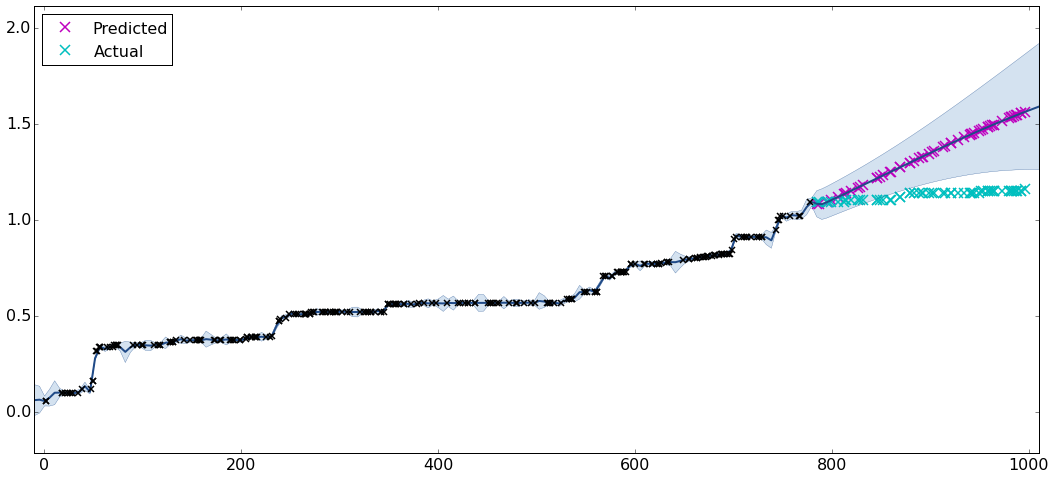

In [44]:
def rmse(x, y):
    return np.sqrt(np.mean(np.square(x - y)))

Xnew = np.ndarray((len(x_test),1), buffer=x_test, dtype=int)
mean, var = m.predict(Xnew)
Ypredict = mean

print "RMSE on test set: %s" % rmse(y_test, Ypredict)
fig = plt.figure()
ax = fig.add_subplot(111)
#ax.errorbar(Xnew, Ypredict, 2*np.sqrt(var), color='r', marker='x', linestyle=".")
ax.plot(Xnew, Ypredict, 'mx', mew=1.5, ms=10, label="Predicted")
ax.plot(x_test, y_test, 'cx', mew=1.5, ms=10, label="Actual")
ax.legend(loc=2, numpoints=1)
model_plot = m.plot(ax=ax, plot_limits=[-10, 1010])